In [1]:
%pylab inline
import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label
output_notebook()

from glob import glob
import gensim
from nltk.corpus import stopwords

from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy
from time import time
from pathlib import Path

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [2]:
corpus, target = [], []

stopw = stopwords.words("english")
for file in glob("dataset/*labelled.txt"):
    texts = open(file).read()
    i = 0
    for line in texts.splitlines():
        
        try:
            target.append(int(line.split("\t")[-1]))
            
            sc = gensim.utils.simple_preprocess(line) # sentence candidate
            sc = [i for i in sc if i not in stopw]
            corpus.append(sc)
        except:
            print(file, i)
        i += 1

assert len(corpus) == len(target), f"corpus: {len(corpus)} | target: {len(target)}"

dataset/imdb_labelled.txt 178
dataset/imdb_labelled.txt 968


In [3]:
max_sentence = 0
for i in corpus:
    len_sentence = len(i)
    if len_sentence > max_sentence:
        max_sentence = len_sentence
print("max_sentence: ", max_sentence)

max_sentence:  44


In [4]:
skip_gram = gensim.models.Word2Vec(corpus, size=max_sentence, sg=1, iter=2000, min_count=1)

In [5]:
pca = PCA(n_components=2)
XY = pca.fit_transform(skip_gram[skip_gram.wv.vocab])

/home/lincoln/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [6]:
source = ColumnDataSource(data=dict(x=XY[:, 0], y=XY[:, 1], labels=list(skip_gram.wv.vocab.keys())))
p = figure(plot_width=600, plot_height=600)
p.scatter(x='x', y='y', size=8, source=source)
labels = LabelSet(x='x', y='y', text='labels', level='glyph',
              x_offset=5, y_offset=5, source=source, render_mode='canvas')

p.add_layout(labels)
show(p)

In [7]:
del XY, source, p, labels, pca

In [8]:
def make_matrix(phrase, model_vec, n, stop_words):
    if type(phrase) is str:
        phrase = gensim.utils.simple_preprocess(phrase)
        phrase = [i for i in phrase if i not in stop_words]
    
    out = np.zeros((n, n))
    for i, label in enumerate(phrase):
        if label in model_vec.wv.vocab.keys():
            out[i, :] = model_vec[label]

    return out

/home/lincoln/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


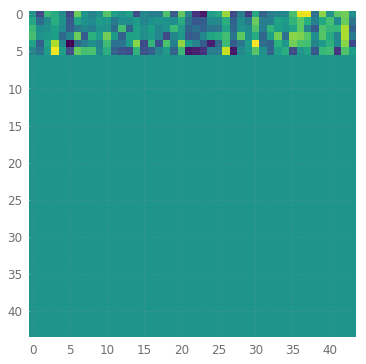

In [9]:
figsize(6, 6)
imshow(make_matrix(corpus[442], skip_gram, max_sentence, stopw));

In [10]:
class Data(Dataset):
    def __init__(self, data, target, model, n, stop_words):
        self.n = n
        self.data = torch.FloatTensor(
            [make_matrix(i, model, n, stop_words) for i in data]
        )
        self.target =  torch.LongTensor([int(i) for i in target])
        self._len = len(target)
        
    def __getitem__(self, x):
        return self.data[x].view(1, self.n, self.n), self.target[x]
    
    def __len__(self):
        return self._len

In [11]:
data = Data(corpus, target, skip_gram, max_sentence, stopw)

/home/lincoln/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [12]:
data[4][0].shape

torch.Size([1, 44, 44])

In [13]:
train_data, test_data, train_target, test_target = train_test_split(corpus, target, test_size=0.25)

data_train = Data(train_data, train_target, skip_gram, max_sentence, stopw)
data_test = Data(test_data, test_target, skip_gram, max_sentence, stopw)

/home/lincoln/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [14]:
print(f"\
lengh train: {data_train._len}\n\
lengh test: {data_test._len}")

lengh train: 2250
lengh test: 750


In [15]:
class CNN(nn.Module):
    def __init__(self, lin_in, lin_out):
        super(CNN, self).__init__()
        
        self.conv0 = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(16, 32, 5, stride=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.linear = nn.Linear(lin_in, lin_out)
        
    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = x.view(x.shape[0], -1)
        x = torch.sigmoid(self.linear(x))
        return x
        

In [16]:
cnn = CNN(32, 2)
t = next(iter(DataLoader(data_train, batch_size=3)))
print(cnn(t[0]))
del t

tensor([[0.5410, 0.4173],
        [0.5415, 0.4316],
        [0.5335, 0.4423]], grad_fn=<SigmoidBackward>)


In [17]:
train_loader = DataLoader(data_train, batch_size=int(data_train._len/3), shuffle=True)
test_loader = DataLoader(data_test, batch_size=data_test._len)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

trainer = create_supervised_trainer(
    cnn, optimizer, criterion
)

evaluator = create_supervised_evaluator(
    cnn,
    metrics={
        "accuracy": Accuracy()
    },
    non_blocking=True
)

In [19]:
@trainer.on(Events.STARTED)
def start_prepare(trainer):
    trainer._loss = []
    trainer._accuracy_train = []
    trainer._accuracy_test = []
    trainer._init_time = time()
    trainer._csv_path = "results.csv"
    if not Path(trainer._csv_path):
        with open(trainer._csv_path, "x") as f:
            f.write("epoch, loss, accuracy_train, accuracy_test, model\n")
            f.close()

@trainer.on(Events.EPOCH_COMPLETED)
def registry_progress(trainer):
    evaluator.run(train_loader)
    loss = trainer.state.output
    trainer._loss.append(
        loss
    )
    accuracy_train = evaluator.state.metrics["accuracy"]
    trainer._accuracy_train.append(
        accuracy_train
    )
    
    evaluator.run(test_loader)
    accuracy_test = evaluator.state.metrics["accuracy"]
    trainer._accuracy_test.append(
        accuracy_test
    )

    with open(trainer._csv_path, "a") as f:
        f.write(f"{trainer.state.epoch}, {loss}, {accuracy_train}, {accuracy_test}, cnn_2d\n")
        f.close()

@trainer.on(Events.EPOCH_COMPLETED)
def progress_log(trainer):
    if trainer.state.epoch % 10 == 0:
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics
        print(f"epoch: {trainer.state.epoch:<2} | " + \
              f"accuracy: {metrics['accuracy']:.2f} | " + \
              f"loss: {trainer.state.output:.2f}")
              
@trainer.on(Events.COMPLETED)
def summary(trainer):
    print(f"\n\
    ---\n\
    epochs: {trainer.state.epoch}\n\
    total time: {time() - trainer._init_time:.0f} seconds\n\n\
    \t\t loss \t train \t test \n\
    init\t {trainer._loss[0]:.3f} \t {trainer._accuracy_train[0]:.3f} \t {trainer._accuracy_test[0]:.3f}\n\
    end\t {trainer._loss[-1]:.3f} \t {trainer._accuracy_train[-1]:.3f} \t {trainer._accuracy_test[-1]:.3f}\n\
    ---")
    torch.save(cnn, "saved_models/cnn_2d.pth")


In [20]:
state = trainer.run(train_loader, max_epochs=50)

epoch: 10 | accuracy: 0.64 | loss: 0.68
epoch: 20 | accuracy: 0.68 | loss: 0.65
epoch: 30 | accuracy: 0.71 | loss: 0.61
epoch: 40 | accuracy: 0.74 | loss: 0.57
epoch: 50 | accuracy: 0.76 | loss: 0.57

    ---
    epochs: 50
    total time: 183 seconds

    		 loss 	 train 	 test 
    init	 0.693 	 0.501 	 0.521
    end	 0.570 	 0.764 	 0.696
    ---


/home/lincoln/miniconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


''

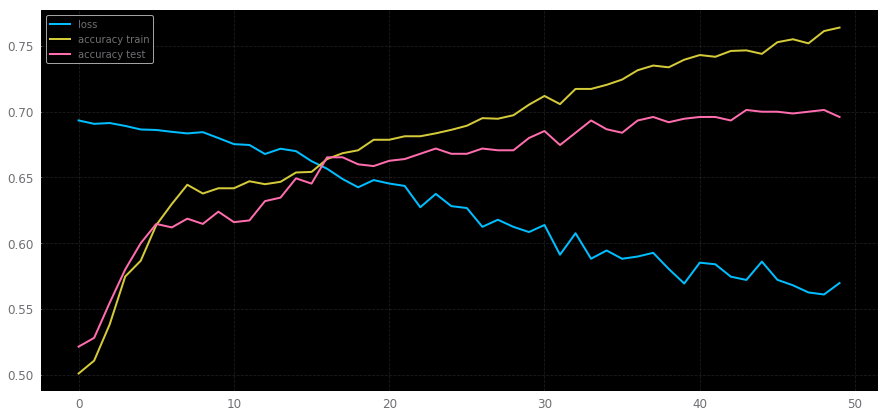

In [21]:
figsize(15, 7)

plot_loss = plot(trainer._loss, label="loss")
plot_train = plot(trainer._accuracy_train, label="accuracy train")
plot_test = plot(trainer._accuracy_test, label="accuracy test")
plt.legend()
;